In [1]:
# Step 0: Install necessary libraries
!pip install wfdb  # For reading PhysioNet WFDB files
!pip install numpy  # For numerical operations
!pip install scipy  # For statistical and signal processing functions
!pip install pandas  # For data manipulation and CSV output

# Import the libraries we'll use
import wfdb  # To read CTU-CHB data files
import numpy as np  # For math operations like mean, std, etc.
from scipy import signal  # For filtering and peak detection
from scipy.stats import skew  # For calculating histogram tendency (skewness)
import pandas as pd  # To store and save the extracted features
import matplotlib.pyplot as plt  # For visualizing signals (optional, but helpful)

# Print a message to confirm setup is complete
print("Setup complete! All libraries are installed and imported.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 65.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
Setup complete! All libraries are installed and imported.


Generating record list for: 1001
Generating list of all files for: 1001
Created local base download directory: ctu_chb_data
Finished downloading files
Loaded record: 1001
Sampling frequency: 4 Hz
FHR signal length: 19200 samples
UC signal length: 19200 samples


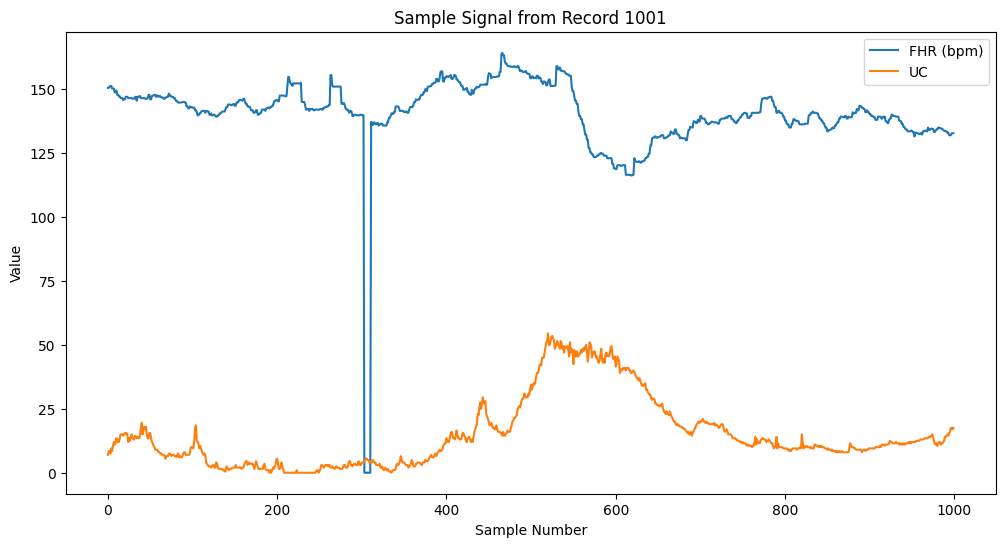

In [2]:
# Step 1: Download and load a sample CTU-CHB recording

# Define the record number (e.g., 1001 is the first file)
record_name = '1001'

# Download the specific record from PhysioNet
# This command fetches the .dat (signal) and .hea (header) files
wfdb.dl_database('ctu-uhb-ctgdb', dl_dir='ctu_chb_data', records=[record_name])

# Load the record into memory
# 'ctu_chb_data/' is the folder where files are downloaded
record = wfdb.rdrecord(f'/content/{record_name}')

# Extract the signals (FHR and UC) and sampling frequency
fhr_signal = record.p_signal[:, 0]  # Fetal heart rate (first column)
uc_signal = record.p_signal[:, 1]   # Uterine contractions (second column)
fs = record.fs  # Sampling frequency (usually 4 Hz)

# Print some basic info to check the data
print(f"Loaded record: {record_name}")
print(f"Sampling frequency: {fs} Hz")
print(f"FHR signal length: {len(fhr_signal)} samples")
print(f"UC signal length: {len(uc_signal)} samples")

# Optional: Plot the first 1000 samples to visualize
plt.figure(figsize=(12, 6))
plt.plot(fhr_signal[:1000], label='FHR (bpm)')
plt.plot(uc_signal[:1000], label='UC')
plt.title(f'Sample Signal from Record {record_name}')
plt.xlabel('Sample Number')
plt.ylabel('Value')
plt.legend()
plt.show()

Signals filtered successfully!
First 5 FHR values (filtered): [-0.44676822 -0.26236279  0.134136    0.42302111  0.29471404]
First 5 UC values (filtered): [0.75999288 1.9033138  2.17716901 1.88188574 1.98462772]


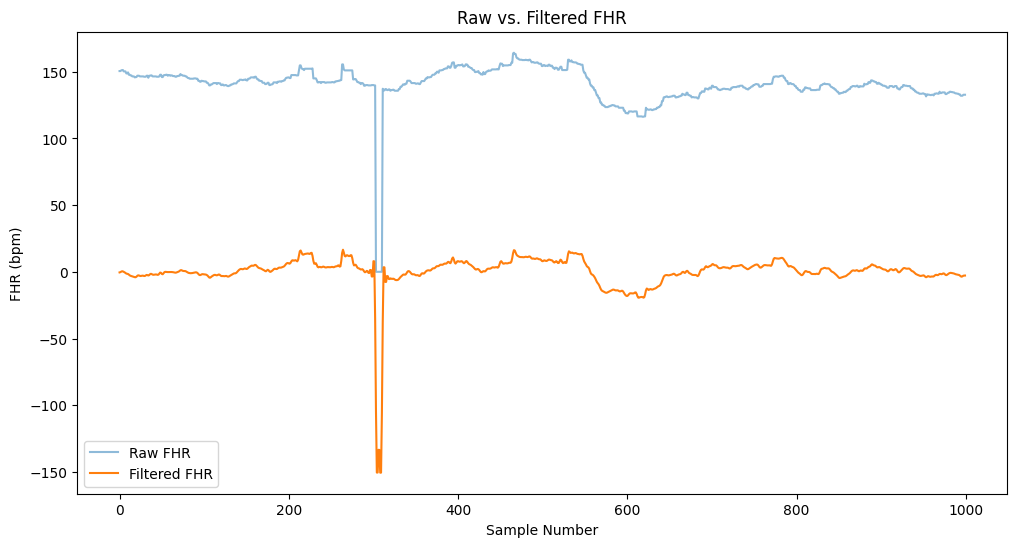

In [3]:
# Step 2: Preprocess the signals (noise filtering)

# Define bandpass filter parameters
lowcut = 0.01  # Low frequency cutoff (Hz) to remove slow drifts
highcut = 1.0  # High frequency cutoff (Hz) to remove fast noise
nyquist = fs / 2  # Nyquist frequency (half the sampling rate)

# Design the bandpass filter
b, a = signal.butter(4, [lowcut / nyquist, highcut / nyquist], btype='band')

# Apply the filter to FHR and UC signals
fhr_filtered = signal.filtfilt(b, a, fhr_signal)
uc_filtered = signal.filtfilt(b, a, uc_signal)

# Replace NaN or infinite values with interpolation (if any)
fhr_filtered = np.nan_to_num(fhr_filtered, nan=np.nanmean(fhr_filtered))
uc_filtered = np.nan_to_num(uc_filtered, nan=np.nanmean(uc_filtered))

# Print to confirm filtering
print("Signals filtered successfully!")
print(f"First 5 FHR values (filtered): {fhr_filtered[:5]}")
print(f"First 5 UC values (filtered): {uc_filtered[:5]}")

# Optional: Plot filtered vs. raw FHR to compare
plt.figure(figsize=(12, 6))
plt.plot(fhr_signal[:1000], label='Raw FHR', alpha=0.5)
plt.plot(fhr_filtered[:1000], label='Filtered FHR')
plt.title('Raw vs. Filtered FHR')
plt.xlabel('Sample Number')
plt.ylabel('FHR (bpm)')
plt.legend()
plt.show()

In [4]:
# Step 3: Calculate Baseline FHR Iteratively

def calculate_baseline_fhr(fhr, fs, max_iter=10, convergence=0.1):
    # Initial baseline is the mean of the entire signal
    baseline = np.mean(fhr)
    window_size = int(10 * 60 * fs)  # 10-minute window in samples (2400 at 4 Hz)

    for _ in range(max_iter):
        # Define accelerations (>15 bpm above baseline for ≥15 sec)
        accel_mask = (fhr >= baseline + 15).astype(int)
        accel_starts = np.where(np.diff(accel_mask) == 1)[0]
        accel_ends = np.where(np.diff(accel_mask) == -1)[0]
        accel_mask_extended = np.zeros_like(fhr)
        for start, end in zip(accel_starts, accel_ends):
            if end - start >= 60:  # 15 sec = 60 samples at 4 Hz
                accel_mask_extended[start:end+1] = 1

        # Define decelerations (<15 bpm below baseline for ≥15 sec)
        decel_mask = (fhr <= baseline - 15).astype(int)
        decel_starts = np.where(np.diff(decel_mask) == 1)[0]
        decel_ends = np.where(np.diff(decel_mask) == -1)[0]
        decel_mask_extended = np.zeros_like(fhr)
        for start, end in zip(decel_starts, decel_ends):
            if end - start >= 60:
                decel_mask_extended[start:end+1] = 1

        # Exclude accelerations and decelerations
        mask = ~(accel_mask_extended.astype(bool) | decel_mask_extended.astype(bool))
        new_baseline = np.mean(fhr[mask])

        # Check for convergence
        if abs(new_baseline - baseline) < convergence:
            break
        baseline = new_baseline

    return baseline

# Calculate the baseline FHR
baseline_fhr = calculate_baseline_fhr(fhr_filtered, fs)

# Print the result
print(f"Baseline FHR: {baseline_fhr:.2f} bpm")

Baseline FHR: -6.12 bpm


In [5]:
# Step 4: Detect Events (Accelerations, Decelerations, Contractions)

# Accelerations
accel_mask = (fhr_filtered >= baseline_fhr + 15).astype(int)
accel_starts = np.where(np.diff(accel_mask) == 1)[0]
accel_ends = np.where(np.diff(accel_mask) == -1)[0]
accelerations = 0
for start, end in zip(accel_starts, accel_ends):
    if end - start >= 60:  # 15 sec = 60 samples
        accelerations += 1
accelerations_per_sec = accelerations / (len(fhr_filtered) / fs)

# Decelerations
decel_mask = (fhr_filtered <= baseline_fhr - 15).astype(int)
decel_starts = np.where(np.diff(decel_mask) == 1)[0]
decel_ends = np.where(np.diff(decel_mask) == -1)[0]
light_decel = severe_decel = prolonged_decel = 0
for start, end in zip(decel_starts, decel_ends):
    duration = (end - start) / fs  # Duration in seconds
    depth = baseline_fhr - np.min(fhr_filtered[start:end+1])
    if duration >= 15:  # Minimum 15 sec
        if duration > 120:  # Prolonged: >2 min
            prolonged_decel += 1
        elif depth > 30:  # Severe: >30 bpm drop
            severe_decel += 1
        elif 15 <= depth <= 30:  # Light: 15-30 bpm drop
            light_decel += 1
light_decel_per_sec = light_decel / (len(fhr_filtered) / fs)
severe_decel_per_sec = severe_decel / (len(fhr_filtered) / fs)
prolonged_decel_per_sec = prolonged_decel / (len(fhr_filtered) / fs)

# Uterine Contractions
uc_mean = np.mean(uc_filtered)
uc_std = np.std(uc_filtered)
uc_threshold = uc_mean + 2 * uc_std  # Threshold for peaks
uc_peaks, _ = signal.find_peaks(uc_filtered, height=uc_threshold, distance=60)
contractions_per_sec = len(uc_peaks) / (len(uc_filtered) / fs)

# Fetal Movement (assumed equal to accelerations)
fetal_movement_per_sec = accelerations_per_sec

# Print results
print(f"Accelerations per sec: {accelerations_per_sec:.6f}")
print(f"Light decelerations per sec: {light_decel_per_sec:.6f}")
print(f"Severe decelerations per sec: {severe_decel_per_sec:.6f}")
print(f"Prolonged decelerations per sec: {prolonged_decel_per_sec:.6f}")
print(f"Uterine contractions per sec: {contractions_per_sec:.6f}")
print(f"Fetal movement per sec: {fetal_movement_per_sec:.6f}")

Accelerations per sec: 0.010208
Light decelerations per sec: 0.000000
Severe decelerations per sec: 0.003333
Prolonged decelerations per sec: 0.000000
Uterine contractions per sec: 0.008542
Fetal movement per sec: 0.010208


In [6]:
# Step 5: Compute Variability Measures

# Window size: 1 minute = 240 samples at 4 Hz
window_size = 240

# Short-Term Variability (STV)
stv_values = []
for i in range(0, len(fhr_filtered) - window_size, window_size):
    window = fhr_filtered[i:i + window_size]
    stv = np.mean(np.abs(np.diff(window)))  # Mean of consecutive differences
    stv_values.append(stv)
mean_stv = np.mean(stv_values)
abnormal_stv = 100 * np.mean((np.array(stv_values) < 1) | (np.array(stv_values) > 5))

# Long-Term Variability (LTV)
ltv_values = []
for i in range(0, len(fhr_filtered) - window_size, window_size):
    window = fhr_filtered[i:i + window_size]
    ltv = np.std(window)  # Standard deviation in window
    ltv_values.append(ltv)
mean_ltv = np.mean(ltv_values)
abnormal_ltv = 100 * np.mean((np.array(ltv_values) < 5) | (np.array(ltv_values) > 25))

# Print results
print(f"Mean short-term variability: {mean_stv:.2f} bpm")
print(f"Abnormal short-term variability (%): {abnormal_stv:.2f}")
print(f"Mean long-term variability: {mean_ltv:.2f} bpm")
print(f"Abnormal long-term variability (%): {abnormal_ltv:.2f}")

Mean short-term variability: 2.37 bpm
Abnormal short-term variability (%): 34.18
Mean long-term variability: 30.55 bpm
Abnormal long-term variability (%): 75.95


In [7]:
# Step 6: Compute Histogram Features

# Create histogram with 1 bpm bins
hist, bin_edges = np.histogram(fhr_filtered, bins=range(int(np.floor(min(fhr_filtered))), int(np.ceil(max(fhr_filtered))) + 1))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Histogram features
histogram_width = max(fhr_filtered) - min(fhr_filtered)
histogram_min = min(fhr_filtered)
histogram_max = max(fhr_filtered)
histogram_peaks, _ = signal.find_peaks(hist, height=1)
histogram_number_of_peaks = len(histogram_peaks)
histogram_number_of_zeroes = np.sum(hist == 0)
histogram_mode = bin_centers[np.argmax(hist)]
histogram_mean = np.mean(fhr_filtered)
histogram_median = np.median(fhr_filtered)
histogram_variance = np.var(fhr_filtered)
histogram_tendency = skew(fhr_filtered)

# Print results
print(f"Histogram width: {histogram_width:.2f}")
print(f"Histogram min: {histogram_min:.2f}")
print(f"Histogram max: {histogram_max:.2f}")
print(f"Number of peaks: {histogram_number_of_peaks}")
print(f"Number of zeroes: {histogram_number_of_zeroes}")
print(f"Mode: {histogram_mode:.2f}")
print(f"Mean: {histogram_mean:.2f}")
print(f"Median: {histogram_median:.2f}")
print(f"Variance: {histogram_variance:.2f}")
print(f"Tendency (skewness): {histogram_tendency:.2f}")

Histogram width: 376.86
Histogram min: -186.14
Histogram max: 190.72
Number of peaks: 77
Number of zeroes: 118
Mode: 1.50
Mean: -0.01
Median: 2.48
Variance: 1281.77
Tendency (skewness): -0.84


In [8]:
# Step 7: Combine Features and Save as CSV

# List of features matching your dataset
features = {
    'baseline_value': baseline_fhr,
    'accelerations': accelerations_per_sec,
    'fetal_movement': fetal_movement_per_sec,
    'uterine_contractions': contractions_per_sec,
    'light_decelerations': light_decel_per_sec,
    'severe_decelerations': severe_decel_per_sec,
    'prolongued_decelerations': prolonged_decel_per_sec,
    'abnormal_short_term_variability': abnormal_stv,
    'mean_value_of_short_term_variability': mean_stv,
    'percentage_of_time_with_abnormal_long_term_variability': abnormal_ltv,
    'mean_value_of_long_term_variability': mean_ltv,
    'histogram_width': histogram_width,
    'histogram_min': histogram_min,
    'histogram_max': histogram_max,
    'histogram_number_of_peaks': histogram_number_of_peaks,
    'histogram_number_of_zeroes': histogram_number_of_zeroes,
    'histogram_mode': histogram_mode,
    'histogram_mean': histogram_mean,
    'histogram_median': histogram_median,
    'histogram_variance': histogram_variance,
    'histogram_tendency': histogram_tendency
}

# Create a DataFrame (one row for this record)
df = pd.DataFrame([features])

# Save to CSV
df.to_csv('ctu_chb_features.csv', index=False)

# Display the DataFrame
print("Extracted features for record 1001:")
print(df)

print("Features saved to 'ctu_chb_features.csv'!")

Extracted features for record 1001:
   baseline_value  accelerations  fetal_movement  uterine_contractions  \
0        -6.12309       0.010208        0.010208              0.008542   

   light_decelerations  severe_decelerations  prolongued_decelerations  \
0                  0.0              0.003333                       0.0   

   abnormal_short_term_variability  mean_value_of_short_term_variability  \
0                        34.177215                              2.370616   

   percentage_of_time_with_abnormal_long_term_variability  ...  \
0                                          75.949367       ...   

   histogram_width  histogram_min  histogram_max  histogram_number_of_peaks  \
0       376.861244    -186.143861     190.717384                         77   

   histogram_number_of_zeroes  histogram_mode  histogram_mean  \
0                         118             1.5       -0.008503   

   histogram_median  histogram_variance  histogram_tendency  
0          2.483197         

In [10]:
# Step 8: Process All Records (Optional)

# List of all record names (1001 to 1552)
all_records = [str(i) for i in range(1001, 1506)]

# Download all records (this takes time!)
wfdb.dl_database('ctu-uhb-ctgdb', dl_dir='ctu_chb_data', records=all_records)

# Empty list to store feature rows
all_features = []

for record_name in all_records:  # Limit to first 10 for testing; remove [:10] for all
    try:
        # Load record
        record = wfdb.rdrecord(f'/content/drive/MyDrive/MLSA BUP/ctu-chb-intrapartum-cardiotocography-database-1.0.0/{record_name}')
        fhr_signal = record.p_signal[:, 0]
        uc_signal = record.p_signal[:, 1]
        fs = record.fs

        # Filter signals
        b, a = signal.butter(4, [0.01 / (fs / 2), 1.0 / (fs / 2)], btype='band')
        fhr_filtered = signal.filtfilt(b, a, fhr_signal)
        uc_filtered = signal.filtfilt(b, a, uc_signal)
        fhr_filtered = np.nan_to_num(fhr_filtered, nan=np.nanmean(fhr_filtered))
        uc_filtered = np.nan_to_num(uc_filtered, nan=np.nanmean(uc_filtered))

        # Calculate all features (reuse previous code)
        baseline_fhr = calculate_baseline_fhr(fhr_filtered, fs)

        accel_mask = (fhr_filtered >= baseline_fhr + 15).astype(int)
        accel_starts = np.where(np.diff(accel_mask) == 1)[0]
        accel_ends = np.where(np.diff(accel_mask) == -1)[0]
        accelerations = sum(1 for s, e in zip(accel_starts, accel_ends) if e - s >= 60)
        accelerations_per_sec = accelerations / (len(fhr_filtered) / fs)

        decel_mask = (fhr_filtered <= baseline_fhr - 15).astype(int)
        decel_starts = np.where(np.diff(decel_mask) == 1)[0]
        decel_ends = np.where(np.diff(decel_mask) == -1)[0]
        light_decel = severe_decel = prolonged_decel = 0
        for start, end in zip(decel_starts, decel_ends):
            duration = (end - start) / fs
            depth = baseline_fhr - np.min(fhr_filtered[start:end+1])
            if duration >= 15:
                if duration > 120:
                    prolonged_decel += 1
                elif depth > 30:
                    severe_decel += 1
                elif 15 <= depth <= 30:
                    light_decel += 1
        light_decel_per_sec = light_decel / (len(fhr_filtered) / fs)
        severe_decel_per_sec = severe_decel / (len(fhr_filtered) / fs)
        prolonged_decel_per_sec = prolonged_decel / (len(fhr_filtered) / fs)

        uc_threshold = np.mean(uc_filtered) + 2 * np.std(uc_filtered)
        uc_peaks, _ = signal.find_peaks(uc_filtered, height=uc_threshold, distance=60)
        contractions_per_sec = len(uc_peaks) / (len(uc_filtered) / fs)
        fetal_movement_per_sec = accelerations_per_sec

        stv_values = [np.mean(np.abs(np.diff(fhr_filtered[i:i + window_size])))
                      for i in range(0, len(fhr_filtered) - window_size, window_size)]
        mean_stv = np.mean(stv_values)
        abnormal_stv = 100 * np.mean((np.array(stv_values) < 1) | (np.array(stv_values) > 5))

        ltv_values = [np.std(fhr_filtered[i:i + window_size])
                      for i in range(0, len(fhr_filtered) - window_size, window_size)]
        mean_ltv = np.mean(ltv_values)
        abnormal_ltv = 100 * np.mean((np.array(ltv_values) < 5) | (np.array(ltv_values) > 25))

        hist, bin_edges = np.histogram(fhr_filtered, bins=range(int(np.floor(min(fhr_filtered))), int(np.ceil(max(fhr_filtered))) + 1))
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        histogram_width = max(fhr_filtered) - min(fhr_filtered)
        histogram_min = min(fhr_filtered)
        histogram_max = max(fhr_filtered)
        histogram_peaks, _ = signal.find_peaks(hist, height=1)
        histogram_number_of_peaks = len(histogram_peaks)
        histogram_number_of_zeroes = np.sum(hist == 0)
        histogram_mode = bin_centers[np.argmax(hist)]
        histogram_mean = np.mean(fhr_filtered)
        histogram_median = np.median(fhr_filtered)
        histogram_variance = np.var(fhr_filtered)
        histogram_tendency = skew(fhr_filtered)

        # Combine into a feature dictionary
        features = {
            'baseline_value': baseline_fhr,
            'accelerations': accelerations_per_sec,
            'fetal_movement': fetal_movement_per_sec,
            'uterine_contractions': contractions_per_sec,
            'light_decelerations': light_decel_per_sec,
            'severe_decelerations': severe_decel_per_sec,
            'prolongued_decelerations': prolonged_decel_per_sec,
            'abnormal_short_term_variability': abnormal_stv,
            'mean_value_of_short_term_variability': mean_stv,
            'percentage_of_time_with_abnormal_long_term_variability': abnormal_ltv,
            'mean_value_of_long_term_variability': mean_ltv,
            'histogram_width': histogram_width,
            'histogram_min': histogram_min,
            'histogram_max': histogram_max,
            'histogram_number_of_peaks': histogram_number_of_peaks,
            'histogram_number_of_zeroes': histogram_number_of_zeroes,
            'histogram_mode': histogram_mode,
            'histogram_mean': histogram_mean,
            'histogram_median': histogram_median,
            'histogram_variance': histogram_variance,
            'histogram_tendency': histogram_tendency
        }
        all_features.append(features)
        print(f"Processed record: {record_name}")
    except Exception as e:
        print(f"Error processing {record_name}: {e}")

# Create DataFrame and save
df_all = pd.DataFrame(all_features)
df_all.to_csv('ctu_chb_all_features.csv', index=False)
print("All features saved to 'ctu_chb_all_features.csv'!")

Generating record list for: 1001
Generating record list for: 1002
Generating record list for: 1003
Generating record list for: 1004
Generating record list for: 1005
Generating record list for: 1006
Generating record list for: 1007
Generating record list for: 1008
Generating record list for: 1009
Generating record list for: 1010
Generating record list for: 1011
Generating record list for: 1012
Generating record list for: 1013
Generating record list for: 1014
Generating record list for: 1015
Generating record list for: 1016
Generating record list for: 1017
Generating record list for: 1018
Generating record list for: 1019
Generating record list for: 1020
Generating record list for: 1021
Generating record list for: 1022
Generating record list for: 1023
Generating record list for: 1024
Generating record list for: 1025
Generating record list for: 1026
Generating record list for: 1027
Generating record list for: 1028
Generating record list for: 1029
Generating record list for: 1030
Generating